In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [16]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
df = pd.read_csv("../raw_data/data/merged_daily_data.csv")

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [19]:
sequence = 5
target = "BDI_Price"

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler.fit(df)
scaled = scaler.transform(df)
scaled_df = pd.DataFrame(scaled)
tmp_df = pd.DataFrame()

BDI_Price_scaled_df = pd.DataFrame(scaled_df[0])
BDI_Price_scaled_df.index = df.index

# tmp_df["BDI_Price_scaled"] = pd.DataFrame(scaled_df[0])
# tmp_df["CSTEEL_price"] = scaled_df[1]
# tmp_df["El_Nino_Temperature"] = scaled_df[2]
# tmp_df["Land Temperature"] = scaled_df[3]
tmp_df["Ocean Temperature"] = scaled_df[4]
# tmp_df["CIP"] = scaled_df[5]

In [22]:
tmp_df.index = df.index

In [23]:
BDI_price_df = pd.DataFrame(df["BDI_Price"])
df = pd.concat([BDI_price_df, tmp_df], axis=1)

In [24]:
import sequential as sq

sequence = sq.Sequential(df)
data_windows = sequence.sequence_data(5, target)
random_windows = sequence.randomize_window(data_windows)

In [25]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
  
train, test = train_test_split(random_windows,
                               test_size=0.3,
                               shuffle=False,
                               random_state=0)

In [27]:
X = organaized_data["train"][0]

y = organaized_data["train"][1]

test_window_feature = organaized_data["test"][0]
test_window_target = organaized_data["test"][1]

In [28]:
organaized_data = sequence.reorganaize_sequence_data(train, test)


In [29]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

scaler = MinMaxScaler()
optimizer = RMSprop(learning_rate=lr_schedule)

In [30]:
def plot_history(history, offset=0, standalizer=StandardScaler):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'][offset:])
    ax[0].plot(history.history['val_loss'][offset:])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    y_data = history.history['mae'][offset:]
    ax[1].plot(history.history['mae'][offset:])
    ax[1].plot(history.history['val_mae'][offset:])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [31]:
es = EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)

In [32]:
#LSTM layers
model = Sequential()
model.add(layers.LSTM(400, activation="tanh", input_shape=(5,1), return_sequences=True))
model.add(layers.LSTM(400, activation="tanh", input_shape=(5,1), return_sequences=False))
model.compile(loss="mse", optimizer=optimizer, metrics="mae")


#Dense layers
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

#compiling model
model.compile(loss="mse", optimizer=optimizer, metrics="mae")
    
result = model.fit(
    X, y, epochs=50, validation_data=(test_window_feature, test_window_target), shuffle=True, callbacks=es
)

Epoch 1/50
159/159 [==============================] - 6s 29ms/step - loss: 6014747.5000 - mae: 1643.8186 - val_loss: 4569082.5000 - val_mae: 1195.0624
Epoch 2/50
159/159 [==============================] - 4s 27ms/step - loss: 3509256.5000 - mae: 1144.5984 - val_loss: 3476843.0000 - val_mae: 1249.6444
Epoch 3/50
159/159 [==============================] - 4s 26ms/step - loss: 3268172.5000 - mae: 1228.1157 - val_loss: 3474033.0000 - val_mae: 1260.2588
Epoch 4/50
159/159 [==============================] - 4s 26ms/step - loss: 3267442.5000 - mae: 1230.0306 - val_loss: 3473091.7500 - val_mae: 1267.8280
Epoch 5/50
159/159 [==============================] - 4s 26ms/step - loss: 3267137.0000 - mae: 1231.5328 - val_loss: 3473738.5000 - val_mae: 1262.0127
Epoch 6/50
159/159 [==============================] - 4s 28ms/step - loss: 3268284.5000 - mae: 1229.0739 - val_loss: 3475561.0000 - val_mae: 1253.6722
Epoch 7/50
159/159 [==============================] - 4s 26ms/step - loss: 3268353.0000 - mae:

array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

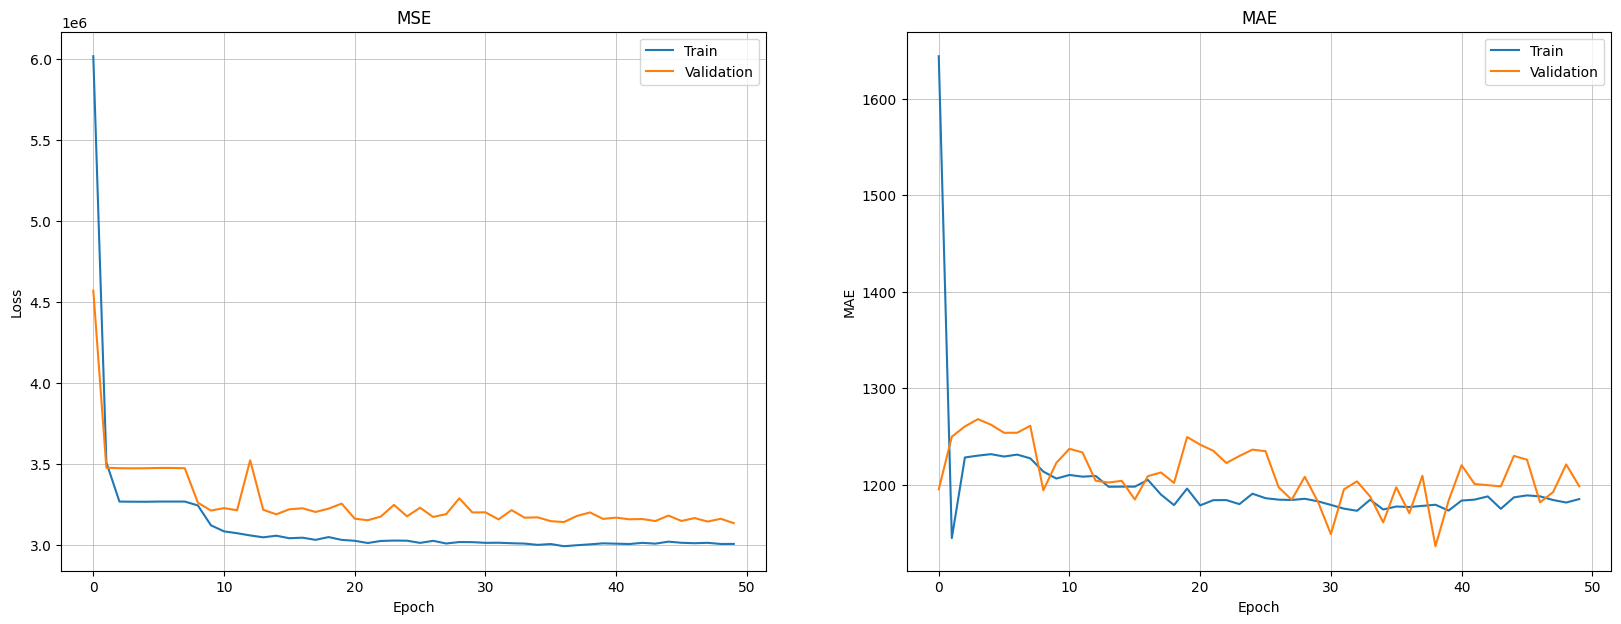

In [33]:
plot_history(result)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 400)            643200    
                                                                 
 lstm_1 (LSTM)               (None, 400)               1281600   
                                                                 
 dense (Dense)               (None, 128)               51328     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,976,257
Trainable params: 1,976,257
Non-trainable params: 0
_________________________________________________________________
